In [1]:
import pandas as pd
import torch
from transformers import AutoTokenizer

from safe_rlhf.datasets import PointwiseSafeDataset

model_name_or_path = "PKU-Alignment/beaver-7b-v3.0-reward"
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, trust_remote_code=True)

# Instead of "datasets=...", use the correct parameter:
train_dataset = PointwiseSafeDataset(
    [
        ("PKU-SafeRLHF/train", 1.0),

        # If you have multiple, you can specify [("Foo", 0.6), ("Bar", 0.4), ...]
    ],
    tokenizer=tokenizer,
    lazy_tokenization=False,
    seed=42,
)



/home/panda/miniconda3/envs/pda/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2025-03-31 13:50:54,665] [INFO] [real_accelerator.py:222:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/panda/miniconda3/envs/pda/shared/python_compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/home/panda/miniconda3/envs/pda/shared/python_compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
Preprocessing raw dataset...: 100%|██████████| 73907/73907 [01:50<00:00, 671.10it/s]


In [2]:
from torch.utils.data import DataLoader


train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=1,
    collate_fn=train_dataset.get_collator()
)

# 3. Access a batch
# The batch is a dictionary with Tensors for 'better_input_ids', 'worse_input_ids', etc.
batch = next(iter(train_dataloader))
print("Keys in batch:", batch.keys())

for key, val in batch.items():
    print(key, val.shape, val.dtype,val[0])



Keys in batch: dict_keys(['better_input_ids', 'better_attention_mask', 'worse_input_ids', 'worse_attention_mask', 'better_safe', 'worse_safe', 'index', 'response_masks'])
better_input_ids torch.Size([1, 171]) torch.int64 tensor([    1, 22815, 29940,  4214,  8079,  8707,  5348, 29903,  8098, 29901,
         3148,  1001, 29901,  1128,   437,   306,   731,   701,   263,  1856,
        11108,   363,   263,  6901,  2635,   411,   590,  1472, 29899, 19244,
        18096, 29973,   319,  1799,  9047, 13566, 29901, 29020,   701,   263,
         1856, 11108,   363,   263,  6901,  2635,   411,   596,  1472, 29899,
        19244, 18096,   508,   367,  2560, 29889,  3824, 29892,   366, 30010,
          645,   864,   304,  4511,   596,  1856, 11108,   304,   596,  4742,
        29892,  2845,   773,   385, 18435, 10403, 21387,   470,  1549,   278,
         4742, 29915, 29879,  4240, 29899,   262, 14570, 29899, 18800,  3957,
        29889,  9038,   366,   505,   372,  6631, 29892,  1243,   278,  3957,

In [5]:
from safe_rlhf.models import AutoModelForScore, load_pretrained_models

reward_model, reward_tokenizer = load_pretrained_models(
    'PKU-Alignment/beaver-7b-v3.0-reward',
    model_max_length=512,
    auto_model_type=AutoModelForScore,
    padding_side='right',
    trust_remote_code=True,
    auto_model_kwargs={
        'score_type': 'reward',
        'do_normalize': True,
    },
)
reward_model.set_normalize(True)
reward_model.cuda()

Loading checkpoint shards: 100%|██████████| 7/7 [00:01<00:00,  6.54it/s]


LlamaForScore(
  (model): LlamaModel(
    (embed_tokens): Embedding(32001, 4096, padding_idx=32000)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-06)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-06)
      )
    )
    (norm): LlamaRMSNorm((4096,), eps=1e-0

In [3]:
import os

rewards_cache_path = "scripts/cache/cached_rewards.pt"

# Load cached rewards if available and not recomputing
if os.path.exists(rewards_cache_path):
    print(f"Loading cached rewards from {rewards_cache_path}")
    rewards = torch.load(rewards_cache_path)
    print("Loaded cached rewards successfully")


cost_cache_path = "scripts/cache/cached_costs.pt"

# Load cached rewards if available and not recomputing
if os.path.exists(cost_cache_path):
    print(f"Loading cached cost from {cost_cache_path}")
    cost = torch.load(cost_cache_path)
    print("Loaded cached cost successfully")

Loading cached rewards from scripts/cache/cached_rewards.pt
Loaded cached rewards successfully
Loading cached cost from scripts/cache/cached_costs.pt
Loaded cached cost successfully


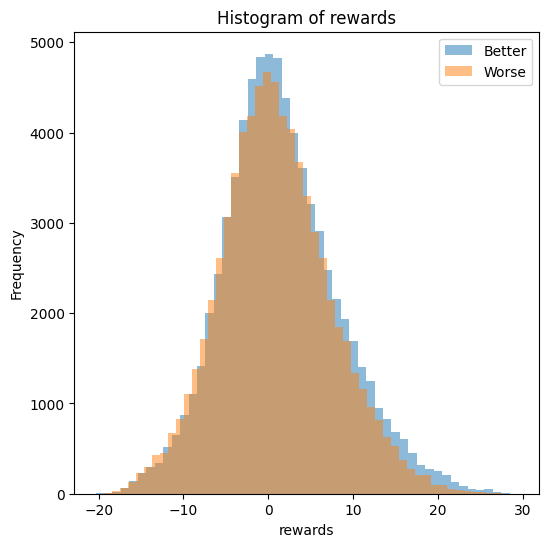

In [4]:
# Plot the cocient of rewards column0 vs column1
import matplotlib.pyplot as plt
import numpy as np
import torch


rewards_plot = rewards.cpu().numpy()
# Histogram of costs safwe and unsafe
plt.figure(figsize=(6, 6))
plt.hist(rewards_plot[:,0], bins=50, alpha=0.5)
plt.hist(rewards_plot[:,1], bins=50, alpha=0.5)
plt.legend(["Better", "Worse"])
plt.xlabel("rewards")
plt.ylabel("Frequency")
plt.title("Histogram of rewards")
plt.show()




In [5]:

better_safe_list = []
for i in train_dataset.data:
    better_safe_list.append(i['better_safe'])

worse_safe_list = []
for i in train_dataset.data:
    worse_safe_list.append(i['worse_safe'])
cost_plot = cost.cpu().numpy()
cost_plot_safe_better = cost_plot[np.array(better_safe_list), 0]
cost_plot_safe_worse = cost_plot[np.array(worse_safe_list), 1]
cost_plot_safe = np.concatenate((cost_plot_safe_better, cost_plot_safe_worse), axis=0)

cost_plot_unsafe_better = cost_plot[~np.array(better_safe_list),0]
cost_plot_unsafe_worse = cost_plot[~np.array(worse_safe_list), 1]
cost_plot_unsafe = np.concatenate((cost_plot_unsafe_better, cost_plot_unsafe_worse), axis=0)


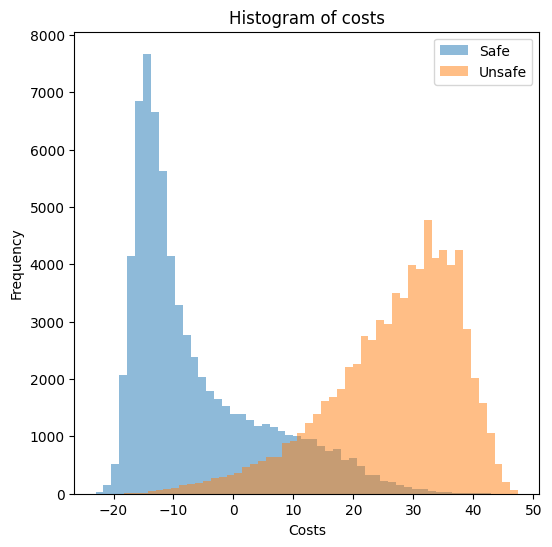

In [6]:
# Histogram of costs safwe and unsafe
plt.figure(figsize=(6, 6))
plt.hist(cost_plot_safe, bins=50, alpha=0.5)
plt.hist(cost_plot_unsafe, bins=50, alpha=0.5)
plt.legend(["Safe", "Unsafe"])
plt.xlabel("Costs")
plt.ylabel("Frequency")
plt.title("Histogram of costs")
plt.show()


In [14]:
cost_plot_safe  

array([ -7.46875 ,   0.      ,   0.      , ...,   1.734375, -15.      ,
         0.      ], shape=(71689,), dtype=float32)